<a href="https://colab.research.google.com/github/nicholasproietti/LGM/blob/Kepler/Kepler_NNs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using Neural Networks to Confirm Exoplanet Discovery in Kepler Data

*Program function*: Build a Neural Networks model solution that, given the characteristics collected by Kepler, is feasible to identify exoplanets.



Import necessary libraries

In [ ]:
import numpy as np
import pandas as pd
from mlxtend.plotting import plot_confusion_matrix
from sklearn.preprocessing import normalize
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import minmax_scale
import torch.nn as nn
import torch.optim
import NeuralNets as mynn
from matplotlib import pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn import metrics
from sklearn.metrics import mean_squared_error, precision_score, confusion_matrix, accuracy_score
import seaborn as sn

Three different neural network: a simpler Perceptron and two Multilayer Perceptrons, one with three hidden layers and the other with two. They also varied in activation function. In the end: five Neural Networks were built.

The data was divided in three parts where 70% was to **training**, 15% to **validation** and 15% to **testing**. The features were normalized using min-max scaling, the validation and training were transformed to using the **DataLoader** from PyTorch. 

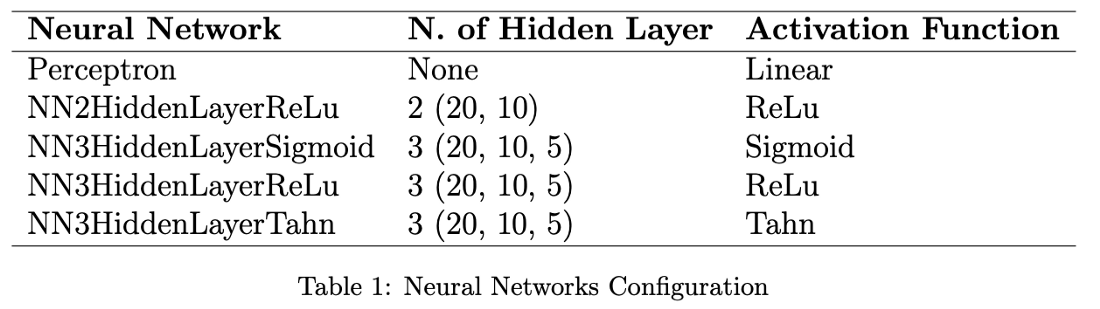

In [ ]:
torch.manual_seed(5)


def data_load():

    features = pd.read_csv('data/exoplanets_features.csv', header=None).values[1:]
    label = pd.read_csv('data/exoplanets_label.csv').values

    features = minmax_scale(features)

    x_train, x_test_validation, y_train, y_test_validation = train_test_split(features, label, random_state=1, test_size=0.3)

    x_test, x_validation, y_test, y_validation = train_test_split(x_test_validation, y_test_validation, test_size=0.5,
                                                                  random_state=1)

    x_train_tensor = torch.tensor(x_train, dtype=torch.float)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float)
    x_validation_tensor = torch.tensor(x_validation, dtype=torch.float)
    y_validation_tensor = torch.tensor(y_validation, dtype=torch.float)
    x_test_tensor = torch.tensor(x_test, dtype=torch.float)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float)

    dataset_train = TensorDataset(x_train_tensor, y_train_tensor)
    dataset_validation = TensorDataset(x_validation_tensor, y_validation_tensor)

    train_loader = DataLoader(dataset=dataset_train, batch_size=x_train.shape[0])
    val_loader = DataLoader(dataset=dataset_validation, batch_size=x_validation.shape[0])

    test_tuple = (x_test_tensor, y_test_tensor)

    return train_loader, val_loader, test_tuple

In [ ]:
def data_loader_review():
    # dataset from

    features = pd.read_csv('data/exoplanets_features.csv', header=None).values[1:]
    label = pd.read_csv('data/exoplanets_label.csv').values

    features = minmax_scale(features)

    x_train, x_test, y_train, y_test = train_test_split(features, label, random_state=1, test_size=0.3)

    x_train_tensor = torch.tensor(x_train, dtype=torch.float)
    y_train_tensor = torch.tensor(y_train, dtype=torch.float)

    x_test_tensor = torch.tensor(x_test, dtype=torch.float)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float)

    dataset_train = TensorDataset(x_train_tensor, y_train_tensor)

    train_loader = DataLoader(dataset=dataset_train, batch_size=x_train.shape[0])

    test_tuple = (x_test_tensor, y_test_tensor)

    return train_loader, 

The training was made using the **Adam** as optimizer, using 0.01 as the **learning rate** and using **Mean Squared Error** as loss function. Two different training were made, one with 100 epochs (**Experiment A**) and another with 50 epochs (**Experiment B**). All the other configurations of the training remained the same.

In [ ]:
def training(model_, train_loader, val_loader, epochs=100, lr=0.01, loss_function=nn.MSELoss()):
    train_track = []
    validation_track = []

    optimizer = torch.optim.Adam(model_.parameters(), lr=lr)

    for epoch in range(epochs):

        for x_batch, y_batch in train_loader:

            optimizer.zero_grad()
            output = model_(x_batch)
            loss = loss_function(output, y_batch)
            loss.backward()
            optimizer.step()
            model_.train()
            train_track.append(loss.item())

            with torch.no_grad():
                for x_val, y_val in val_loader:
                    y_out = model_(x_val)
                    val_loss = loss_function(y_val, y_out)

                    validation_track.append(val_loss.item())

    return model_, train_track, validation_track

In [ ]:
def loss_graph(name, train_track, val_track):
    plt.figure(figsize=(9, 5))
    plt.title(name)
    plt.grid(True)

    plt.plot(train_track, label='Train Set Score', color='g')
    plt.legend(loc="best")
    plt.plot(val_track, label='Validation Set Score', color='r')
    plt.legend(loc="best")

    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')

    plt.savefig('experiments/' + name + '.png')
    plt.close()

    plt.figure(figsize=(9, 5))
    plt.title(name)
    plt.grid(True)

    plt.loglog(train_track, label='Train set score', color='g')
    plt.legend(loc="best")
    plt.loglog(val_track, label='Validation Set Score', color='r')
    plt.legend(loc="best")

    plt.xlabel('Epoch')
    plt.ylabel('MSE Loss')

    plt.savefig('experiments/' + name + '_log.png')
    plt.close()

In [ ]:
def evaluation(y_true, y_pred):
    # Print Accuracy, Recall, F1 Score, and Precision metrics.
    print('Evaluation Metrics:')
    print('Accuracy: ' + str(metrics.accuracy_score(y_true, y_pred)))
    print('Recall: ' + str(metrics.recall_score(y_true, y_pred)))
    print('Precision: ' + str(metrics.precision_score(y_true, y_pred)))
    print('F1 Score: ' + str(metrics.f1_score(y_true, y_pred)))

    # Print Confusion Matrix
    print('\nConfusion Matrix:')
    print(' TN,  FP, FN, TP')
    print(confusion_matrix(y_true, y_pred).ravel())
    return confusion_matrix(y_true, y_pred).ravel()

In [ ]:
def evaluate_matrix_graph(name, y_true, y_pred):
    e = evaluation(y_true, y_pred)

    binary_matrix = np.array([e[:2], e[2:]])

    fig, ax = plot_confusion_matrix(conf_mat=binary_matrix)
    plt.savefig('experiments/' + name + '_evaluate_matrix.png')

In [ ]:
def report_experiment(name, y_true, y_pred):

    f = open("experiments/report.txt", "a")
    f.write(name)
    f.write('\nEvaluation Metrics:')
    f.write('\nAccuracy: ' + str(metrics.accuracy_score(y_true, y_pred)))
    f.write('\nRecall: ' + str(metrics.recall_score(y_true, y_pred)))
    f.write('\nPrecision: ' + str(metrics.precision_score(y_true, y_pred)))
    f.write('\nF1 Score: ' + str(metrics.f1_score(y_true, y_pred)))

    f.write('\nConfusion Matrix:')
    f.write('\nTN,  FP, FN, TP')
    f.write("\n" + str(confusion_matrix(y_true, y_pred).ravel()))
    f.write('\n-----------------------------------------------------------\n')
    f.close()

In [ ]:
def experiment_A():

    models = [mynn.Perceptron(), mynn.NN2HiddenLayer(), mynn.NN3HiddenLayer(),
              mynn.NN3HiddenLayer(act_function=nn.Tanh()), mynn.NN3HiddenLayer(act_function=nn.ReLU())]

    for model in models:
        train_loader, val_loader, test_tuple = data_load()
        m, train_track, val_track = training(model, train_loader, val_loader)

        exp_name = model._get_name() + str(model.act_function)

        loss_graph(exp_name, train_track, val_track)

        m.eval()
        pred = m(test_tuple[0])
        pred = pred.detach().numpy()
        result = pred

        #limiar
        result = np.where(result < 0.5, 0, result)
        result = np.where(result != 0, 1, result)

        report_experiment(exp_name, test_tuple[1].detach().numpy(), result)

        evaluate_matrix_graph(exp_name, test_tuple[1].detach().numpy(), result)
        torch.save(model, 'experiments/' + exp_name +'_model.pt')

In [ ]:
def experiment_B():

    models = [mynn.Perceptron(), mynn.NN2HiddenLayer(), mynn.NN3HiddenLayer(),
              mynn.NN3HiddenLayer(act_function=nn.Tanh()), mynn.NN3HiddenLayer(act_function=nn.ReLU())]

    for model in models:
        train_loader, val_loader, test_tuple = data_load()
        m, train_track, val_track = training(model, train_loader, val_loader, epochs=50)

        exp_name = model._get_name() + str(model.act_function)

        loss_graph(exp_name, train_track, val_track)

        m.eval()
        pred = m(test_tuple[0])
        pred = pred.detach().numpy()
        result = pred

        #limiar
        result = np.where(result < 0.5, 0, result)
        result = np.where(result != 0, 1, result)

        report_experiment(exp_name, test_tuple[1].detach().numpy(), result)

        evaluate_matrix_graph(exp_name, test_tuple[1].detach().numpy(), result)

        torch.save(model, 'experiments/' + exp_name +'_model.pt')

Evaluation Metrics:
Accuracy: 0.9521367521367521
Recall: 0.9397394136807817
Precision: 0.9681208053691275
F1 Score: 0.9537190082644628

Confusion Matrix:
 TN,  FP, FN, TP
[537  19  37 577]
Evaluation Metrics:
Accuracy: 0.9555555555555556
Recall: 0.9511400651465798
Precision: 0.9636963696369637
F1 Score: 0.9573770491803277

Confusion Matrix:
 TN,  FP, FN, TP
[534  22  30 584]
Evaluation Metrics:
Accuracy: 0.9564102564102565
Recall: 0.9511400651465798
Precision: 0.9652892561983472
F1 Score: 0.9581624282198523

Confusion Matrix:
 TN,  FP, FN, TP
[535  21  30 584]
Evaluation Metrics:
Accuracy: 0.9572649572649573
Recall: 0.9511400651465798
Precision: 0.9668874172185431
F1 Score: 0.9589490968801314

Confusion Matrix:
 TN,  FP, FN, TP
[536  20  30 584]
Evaluation Metrics:
Accuracy: 0.9547008547008548
Recall: 0.9495114006514658
Precision: 0.9636363636363636
F1 Score: 0.9565217391304347

Confusion Matrix:
 TN,  FP, FN, TP
[534  22  31 583]


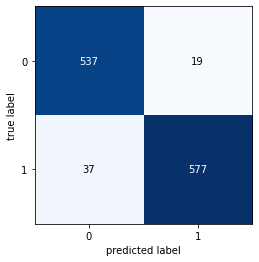

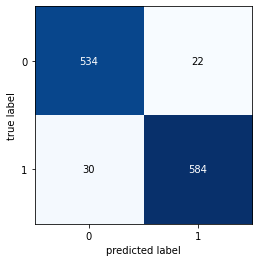

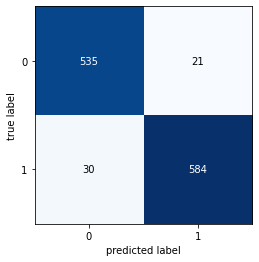

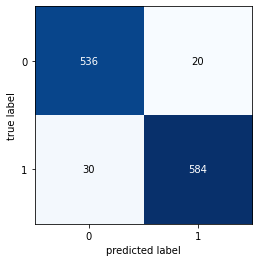

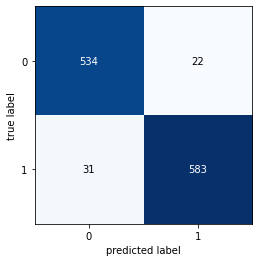

In [ ]:
experiment_A()

Evaluation Metrics:
Accuracy: 0.9538461538461539
Recall: 0.9429967426710097
Precision: 0.9682274247491639
F1 Score: 0.9554455445544555

Confusion Matrix:
 TN,  FP, FN, TP
[537  19  35 579]
Evaluation Metrics:
Accuracy: 0.9555555555555556
Recall: 0.9446254071661238
Precision: 0.9698996655518395
F1 Score: 0.9570957095709571

Confusion Matrix:
 TN,  FP, FN, TP
[538  18  34 580]
Evaluation Metrics:
Accuracy: 0.7205128205128205
Recall: 0.9820846905537459
Precision: 0.6561479869423286
F1 Score: 0.786692759295499

Confusion Matrix:
 TN,  FP, FN, TP
[240 316  11 603]
Evaluation Metrics:
Accuracy: 0.9564102564102565
Recall: 0.9495114006514658
Precision: 0.966832504145937
F1 Score: 0.9580936729663106

Confusion Matrix:
 TN,  FP, FN, TP
[536  20  31 583]
Evaluation Metrics:
Accuracy: 0.9547008547008548
Recall: 0.9446254071661238
Precision: 0.9682804674457429
F1 Score: 0.9563066776586975

Confusion Matrix:
 TN,  FP, FN, TP
[537  19  34 580]


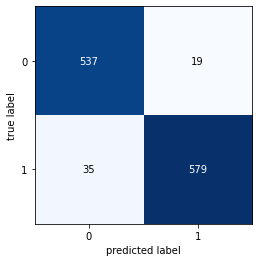

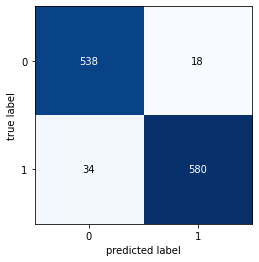

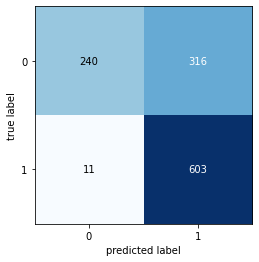

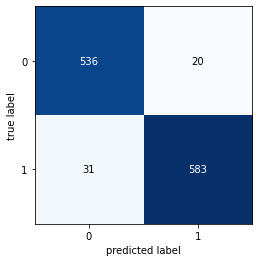

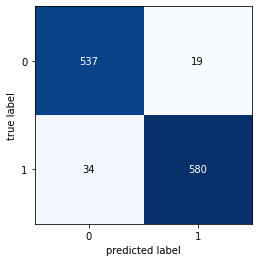

In [ ]:
experiment_B()

### Training Loss during Experiment A (i.e. 100 epochs)

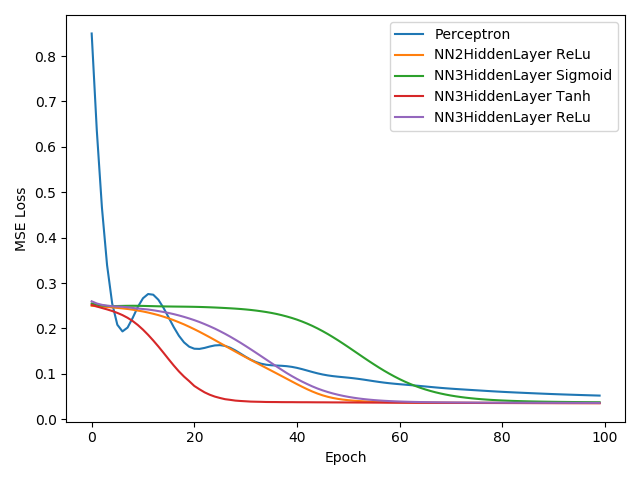

### Training Loss during Experiment B (i.e. 50 epochs)

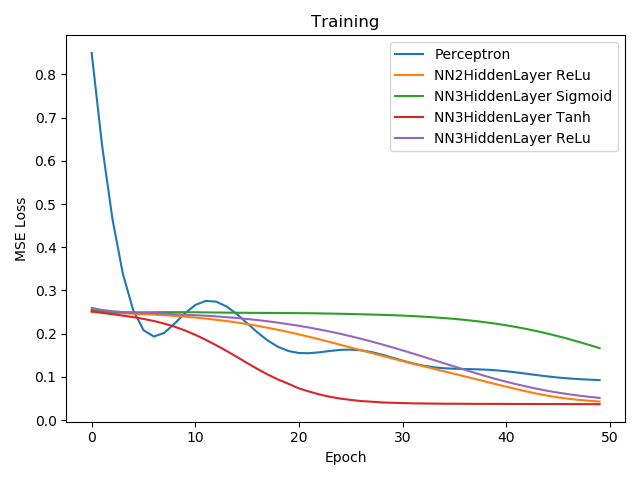

### Table with the results using different all 10 different networks configurations

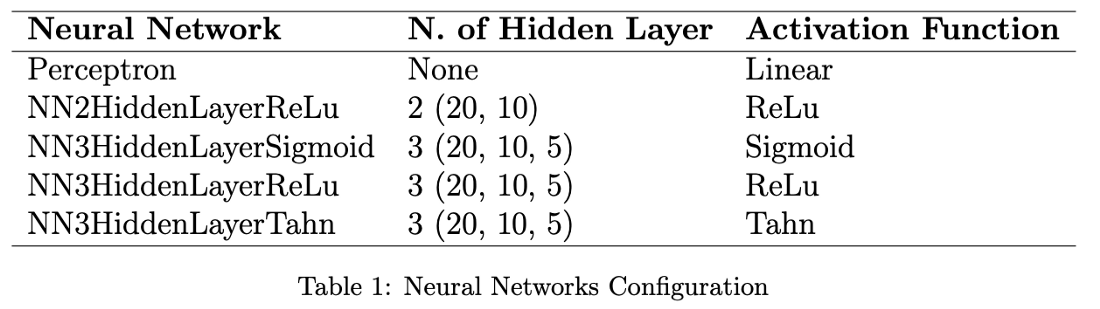

As we could see that the results of the experiments had all very close values of performance.

The least complex Neural Network could bring us a very similar result to the ones with more layers. 